In [22]:
import pandas as pd
import numpy as np
import datetime
import plotly
from plotly import graph_objects as go
pd.set_option('display.max_rows', 100)

%load_ext autoreload

from charts import plot_line, plot_bar, plot_peak, print_charts_country
from features import add_variables_covid, add_variables_apple, join_series_day_since, join_series_date

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [511]:
date_apple = '2020-05-13'

In [488]:
def apple_filter_region(df, region):
    df_region = df[df.region == region].T
    df_region.columns = df_region.loc['transportation_type', :]
    df_region = df_region[~df_region.index.isin(['geo_type', 'region', 'transportation_type', 'alternative_name'])]
    
    df_region['dates'] = pd.to_datetime(df_region.index)
    df_region.set_index('dates', inplace=True)
    df_region = df_region.astype('float')
    df_region['region'] = region
    
    return df_region

In [489]:
def add_forecast_prophet(df_in, column, window=60, ):
    from fbprophet import Prophet
    df = df_in.loc[:, [column]].dropna()
    df['ds'] = df.index
    df.columns = ['y', 'ds']
    m = Prophet()
    m.fit(df)
    future = m.make_future_dataframe(periods=window)
    forecast = m.predict(future)
    forecast.set_index(forecast.ds, inplace=True)
    forecast = forecast.loc[:, ['yhat', 'yhat_lower', 'yhat_upper']]
    df_extra_dates = pd.DataFrame({ 'day': pd.Series([max(df_in.index) + datetime.timedelta(1), max(df_in.index) + datetime.timedelta(window)])})
    df_extra_dates.set_index('day',inplace=True)
    df_extra_dates = df_extra_dates.asfreq('D')
    df_in = df_in.append(df_extra_dates)
    df_result = pd.concat([df_in, forecast ], axis=1)
    df_result[f'{column}_pred'] = df_result.loc[df_result[column].isnull() == True, ['yhat']]
    
    return df_result


In [490]:
def prepare_df_country(df_confirmed, df_dead, country, date_cutoff='2020-03-15'):
    try:
        pop = df_population.loc[df_population.country == country, 'population'].values[0]
    except:
        print('No population data for :', country)
        return False
    
    df = df_confirmed.loc[df_confirmed.index >= date_cutoff, [country]]
    df.columns = ['confirmed']
    df = add_variables_covid(df, population=pop)

    df_d = df_dead.loc[df_dead.index >= date_cutoff, [country]]
    df_d.columns = ['dead']
    df = df.merge(df_d, left_index=True, right_index=True)
    df = add_variables_covid(df, column='dead', population=pop)
    
    return df

In [491]:
def melt_apple_df(df_apple):
    _list = list()
    for region in df_apple.region.unique():
        df = apple_filter_region(df_apple, region)
        df = add_variables_apple(dfapple_region)
        _list.append(df)
    return pd.concat([df for df in _list])

In [492]:
def melt_rki_df(df_rki_germany):
    _list = list()
    for land in df_rki_germany.land.unique():
        df = df_rki_germany.loc[df_rki_germany.land == land, :].copy()
        pop = int(df.loc[df.land==land, 'population'][0])
        df = add_variables_covid(df, 'confirmed', population=pop)
        df = add_variables_covid(df, 'dead', population=pop)
        _list.append(df)
    return pd.concat([df for df in _list])

In [493]:
type(df_apple_processed) == pd.core.frame.DataFrame

True

In [494]:
def melt_jhu_df(df_confirmed, df_dead):
    _list = list()
    for country in df_confirmed.columns:
        df = prepare_df_country(df_confirmed, df_dead, country, date_cutoff='2020-03-15')
        if type(df) == pd.core.frame.DataFrame:
            _list.append(df)
    pd.concat([df for df in _list])

# World Bank Data

In [28]:
import world_bank_data as wb

countries = wb.get_countries()

# population = wb.get_series('SP.POP.TOTL', mrv=1)  # Most recent value
population = wb.get_series('SP.POP.TOTL', id_or_value='id', simplify_index=True, mrv=1)

# Aggregate region, country and population
df_population = countries[['region', 'name']].rename(columns={'name': 'country_wb'}).loc[countries.region != 'Aggregates']
df_population['population'] = population
df_population['country_wb'] = df_population['country_wb'].astype('string')
df_population['iso_code'] = df_population.index
df_population.head(1)

,region,country_wb,population,iso_code
id,,,,
ABW,Latin America & Caribbean,Aruba,105845.0,ABW


In [512]:
date_now = datetime.datetime.strftime(datetime.datetime.utcnow(), "%Y-%m-%d")

dfapple = pd.read_csv(f"../AppleMobilty/applemobilitytrends-{date_apple}.csv")

dfcovid_conf = pd.read_csv("../covid-19-JHU CSSE/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")
dfcovid_dead = pd.read_csv("../covid-19-JHU CSSE/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")
df_uid = pd.read_csv("../covid-19-JHU CSSE/csse_covid_19_data/UID_ISO_FIPS_LookUp_Table.csv")

df_uid = df_uid.loc[df_uid['Province_State'].isnull() == True, ['iso3', 'Country_Region']]
df_uid.columns = ['iso_code', 'country']

dfcovid_conf.columns = ['state', 'country', 'lat', 'lng'] + list(dfcovid_conf.columns[4:])
dfcovid_dead.columns = ['state', 'country', 'lat', 'lng'] + list(dfcovid_dead.columns[4:])
dfcovid_conf = dfcovid_conf.merge(df_uid, how='outer', on='country', suffixes=('_x', '_y'))
dfcovid_dead = dfcovid_dead.merge(df_uid, how='outer', on='country', suffixes=('_x', '_y'))

df_rki_germany = pd.read_csv("data-RKI-parse/RKI-reports.csv")
df_rki_germany.drop('data', axis=1, inplace=True)

df_population_de = pd.read_csv('german_lander_population.csv')

In [496]:
# dfcovid_conf.loc[dfcovid_conf['country'] == 'China',:].reset_index()

In [497]:
dfcovid_conf = dfcovid_conf.loc[dfcovid_conf['state'].isnull() == True, :]
dfcovid_dead = dfcovid_dead.loc[dfcovid_dead['state'].isnull() == True, :]

In [498]:
df_population = df_population.merge(dfcovid_conf.loc[:, ['iso_code', 'country']].drop_duplicates(), how='inner',  on='iso_code',  suffixes=('_x', '_y'), left_index=False, right_index=False,)

In [499]:
df_population.head()

,region,country_wb,population,iso_code,country_x,country_y,country
0,South Asia,Afghanistan,37172386.0,AFG,Afghanistan,Afghanistan,Afghanistan
1,Sub-Saharan Africa,Angola,30809762.0,AGO,Angola,Angola,Angola
2,Europe & Central Asia,Albania,2866376.0,ALB,Albania,Albania,Albania
3,Europe & Central Asia,Andorra,77006.0,AND,Andorra,Andorra,Andorra
4,Middle East & North Africa,United Arab Emirates,9630959.0,ARE,United Arab Emirates,United Arab Emirates,United Arab Emirates


## Join Population data

In [500]:
df_rki_germany = df_rki_germany.merge(df_population_de, 
                                            how='inner',
                                            left_on='land',
                                            right_on='name',
                                            left_index=False,
                                            right_index=False,
                                            suffixes=('_x', '_y'),)

### Add index to RKI data

In [501]:
df_rki_germany['date'] = df_rki_germany['date'].astype('datetime64[ns]')
df_rki_germany = df_rki_germany.sort_values('date', ascending=True)
df_rki_germany.set_index('date', inplace=True)

## Calculate all German States

### Transpose Confirmed Cases

In [502]:
dfcovid_conf_t = dfcovid_conf.loc[dfcovid_conf['state'].isnull() == True, :].T
dfcovid_conf_t.columns = dfcovid_conf_t.loc['country', :].astype(str)
dfcovid_conf_t.drop(['country'], axis=0, inplace=True)
df_country_coords = dfcovid_conf_t.loc[['lat', 'lng'], :]
dfcovid_conf_t.drop(['lat', 'lng', 'state', 'iso_code'], axis=0, inplace=True)
dfcovid_conf_t['dates'] = dfcovid_conf_t.index
dfcovid_conf_t['dates'] = dfcovid_conf_t['dates'].astype('datetime64[ns]')
dfcovid_conf_t = dfcovid_conf_t.sort_values('dates', ascending=True)
dfcovid_conf_t.set_index('dates', inplace=True)
dfcovid_conf_t = dfcovid_conf_t.astype(float)

### Transpose Dead Cases

In [503]:
dfcovid_dead_t = dfcovid_dead.loc[dfcovid_dead['state'].isnull() == True, :].T
dfcovid_dead_t.columns = dfcovid_dead_t.loc['country', :].astype(str)
dfcovid_dead_t.drop(['country'], axis=0, inplace=True)


dfcovid_dead_t.drop(['lat', 'lng', 'state', 'iso_code'], axis=0, inplace=True)
dfcovid_dead_t['dates'] = dfcovid_dead_t.index
dfcovid_dead_t['dates'] = dfcovid_dead_t['dates'].astype('datetime64[ns]')
dfcovid_dead_t = dfcovid_dead_t.sort_values('dates', ascending=True)
dfcovid_dead_t.set_index('dates', inplace=True)
dfcovid_dead_t = dfcovid_dead_t.astype(float)


# Prepare Datasets

### RKI

In [504]:
df_rki_germany_processed = melt_rki_df(df_rki_germany)

In [505]:
df_rki_germany_processed.head(1)

,land,confirmed,dead,name,iso_code,capital,area,population,dow,weekend,...,dead_change_pct_3w,dead_change_acceleration,dead_change_acceleration_avg3,dead_doubling_days,dead_doubling_days_3w,dead_doubling_days_avg3,dead_doubling_days_3w_avg3,dead_day_since_10,dead_per_100k,dead_change_per_100k
date,,,,,,,,,,,,,,,,,,,,,
2020-03-18,Hesse,432,0,Hesse,HE,Wiesbaden,21115,6265809,2,False,...,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0,0.0,NaN


### Apple

In [513]:
df_apple_processed = melt_apple_df(dfapple)

In [514]:
df_apple_processed.head(1)

transportation_type,driving,transit,walking,region,transit_avg3,transit_l1,transit_l6,change_transit_l6,change_transit,walking_avg3,walking_l1,walking_l6,change_walking_l6,change_walking,driving_avg3,driving_l1,driving_l6,change_pct_driving_l6,change_driving
dates,,,,,,,,,,,,,,,,,,,
2020-01-13,100.0,100.0,100.0,Hamburg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### JHU

In [423]:
df_jhu_processed = melt_jhu_df(dfcovid_conf_t, dfcovid_dead_t)

No population data for : Afghanistan
No population data for : Albania
No population data for : Algeria
No population data for : Andorra
No population data for : Angola
No population data for : Antigua and Barbuda
No population data for : Argentina
No population data for : Armenia
No population data for : Austria
No population data for : Azerbaijan
No population data for : Bahamas
No population data for : Bahrain
No population data for : Bangladesh
No population data for : Barbados
No population data for : Belarus
No population data for : Belgium
No population data for : Benin
No population data for : Bhutan
No population data for : Bolivia
No population data for : Bosnia and Herzegovina
No population data for : Brazil
No population data for : Brunei
No population data for : Bulgaria
No population data for : Burkina Faso
No population data for : Cabo Verde
No population data for : Cambodia
No population data for : Cameroon
No population data for : Central African Republic
No population 

ValueError: No objects to concatenate

In [ ]:
df_jhu_processed.head(1)

In [517]:
df_apple_processed.tail()

transportation_type,driving,transit,walking,region,transit_avg3,transit_l1,transit_l6,change_transit_l6,change_transit,walking_avg3,walking_l1,walking_l6,change_walking_l6,change_walking,driving_avg3,driving_l1,driving_l6,change_pct_driving_l6,change_driving
dates,,,,,,,,,,,,,,,,,,,
2020-05-06,80.84,83.27,75.53,Hamburg,81.0,82.13,59.72,-2.48,1.14,73.0,72.49,56.39,1.95,3.04,81.0,83.00,70.69,0.35,-2.16
2020-05-07,80.72,77.38,73.86,Hamburg,82.0,83.27,57.94,-1.78,-5.89,74.0,75.53,51.57,-4.82,-1.67,81.0,80.84,57.18,-13.51,-0.12
2020-05-08,85.42,81.10,83.04,Hamburg,80.0,77.38,58.90,0.96,3.72,77.0,73.86,59.53,7.96,9.18,82.0,80.72,62.90,5.72,4.70
2020-05-09,85.83,77.12,92.76,Hamburg,79.0,81.10,68.68,9.78,-3.98,83.0,83.04,64.49,4.96,9.72,84.0,85.42,68.07,5.17,0.41
2020-05-10,80.04,78.40,69.39,Hamburg,78.0,77.12,75.16,6.48,1.28,84.0,92.76,70.21,5.72,-23.37,84.0,85.83,78.93,10.86,-5.79


In [515]:
print("Mobility max date:", max(df_apple_processed.index))
print("RKI max date", max(df_rki_germany_processed.index))
print("Covi world max date", max(dfcovid_conf_t.index))
print("Covi world max date", max(dfcovid_dead_t.index))

Mobility max date: 2020-05-10 00:00:00
RKI max date 2020-05-14 00:00:00
Covi world max date 2020-05-12 00:00:00
Covi world max date 2020-05-12 00:00:00


In [509]:
df_rki_germany_processed['iso_code'] = 'DE-' + df_rki_germany_processed['iso_code']

# Save processed data

In [510]:
df_rki_germany_processed.to_csv('data_rki_prepared.csv')
df_apple_processed.to_csv('data_apple_prepared.csv')

----

----

----

In [426]:
df_rki_germany_processed.columns

Index(['land', 'confirmed', 'dead', 'name', 'iso_code', 'capital', 'area',
       'population', 'dow', 'weekend', 'confirmed_avg3', 'confirmed_change',
       'confirmed_change_avg3', 'confirmed_change_3w', 'confirmed_change_pct',
       'confirmed_change_pct_avg3', 'confirmed_change_pct_3w',
       'confirmed_change_acceleration', 'confirmed_change_acceleration_avg3',
       'confirmed_doubling_days', 'confirmed_doubling_days_3w',
       'confirmed_doubling_days_avg3', 'confirmed_doubling_days_3w_avg3',
       'confirmed_active_cases', 'confirmed_peak', 'confirmed_day_since_10',
       'confirmed_per_100k', 'confirmed_change_per_100k', 'dead_avg3',
       'dead_change', 'dead_change_avg3', 'dead_change_3w', 'dead_change_pct',
       'dead_change_pct_avg3', 'dead_change_pct_3w',
       'dead_change_acceleration', 'dead_change_acceleration_avg3',
       'dead_doubling_days', 'dead_doubling_days_3w',
       'dead_doubling_days_avg3', 'dead_doubling_days_3w_avg3',
       'dead_day_since_1

In [458]:
df_rki_germany_processed.head(1)

,land,confirmed,dead,name,iso_code,capital,area,population,dow,weekend,...,dead_change_pct_3w,dead_change_acceleration,dead_change_acceleration_avg3,dead_doubling_days,dead_doubling_days_3w,dead_doubling_days_avg3,dead_doubling_days_3w_avg3,dead_day_since_10,dead_per_100k,dead_change_per_100k
date,,,,,,,,,,,,,,,,,,,,,
2020-03-18,Hesse,432,0,Hesse,DE-HE,Wiesbaden,21115,6265809,2,False,...,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0,0.0,NaN


In [129]:
df_rki_germany_processed['dates'] = df_rki_germany_processed.index
df_rki_germany_processed['rn'] = df_rki_germany_processed.groupby('land')['dates'].rank(method='first', ascending=True)

In [130]:
df_rki_germany_processed['land'].unique()

array(['Hesse', 'Schleswig-Holstein', 'Saxony-Anhalt', 'Saxony',
       'Saarland', 'Rhineland-Palatinate', 'North Rhine-Westphalia',
       'Lower Saxony', 'Hamburg', 'Bremen', 'Brandenburg', 'Berlin',
       'Bavaria', 'Mecklenburg-Western Pomerania', 'Thuringia',
       'Baden-Wuerttemberg'], dtype=object)

In [448]:
import geopandas as gpd

In [449]:
# shapefile = 'geoShapes/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp'
# #Read shapefile using Geopandas
# gdf = gpd.read_file(shapefile)[['ADMIN', 'ADM0_A3', 'geometry']]
# #Rename columns.
# gdf.columns = ['country', 'iso_code', 'geometry']
# gdf.head()

import json
geojson_ = json.load(open(geojson_path, 'r'))

In [481]:
geojson_path =  "/Users/chekanskiy/Documents/projects/deutschlandGeoJSON/2_bundeslaender/4_mittel.geo.json"
df_geojson = gpd.read_file(geojson_path)
# df_geojson.set_index('id', inplace=True, drop=False)
df_geojson.columns = ["iso_code", 'name', 'type','geometry']
df_geojson.head()

DriverError: /Users/chekanskiy/Documents/projects/deutschlandGeoJSON/2_bundeslaender/4_mittel.geo.json: No such file or directory

In [ ]:
df = df_rki_germany_processed.loc[df_rki_germany_processed.index == df_rki_germany_processed.index.max(), ['confirmed', 'land', 'iso_code']]
# df.set_index('iso_code', inplace=True, drop=False)

In [ ]:
# print(gdf[gdf['country'] == 'Antarctica'])
# #Drop row corresponding to 'Antarctica'
# gdf = gdf.drop(gdf.index[159])

merged = df_geojson.loc[:, ['geometry', 'iso_code']].merge(df, on='iso_code') #, right_on='country_code')
merged = merged.loc[:, ['land', 'geometry', 'iso_code', 'confirmed']]
merged.index=merged.iso_code

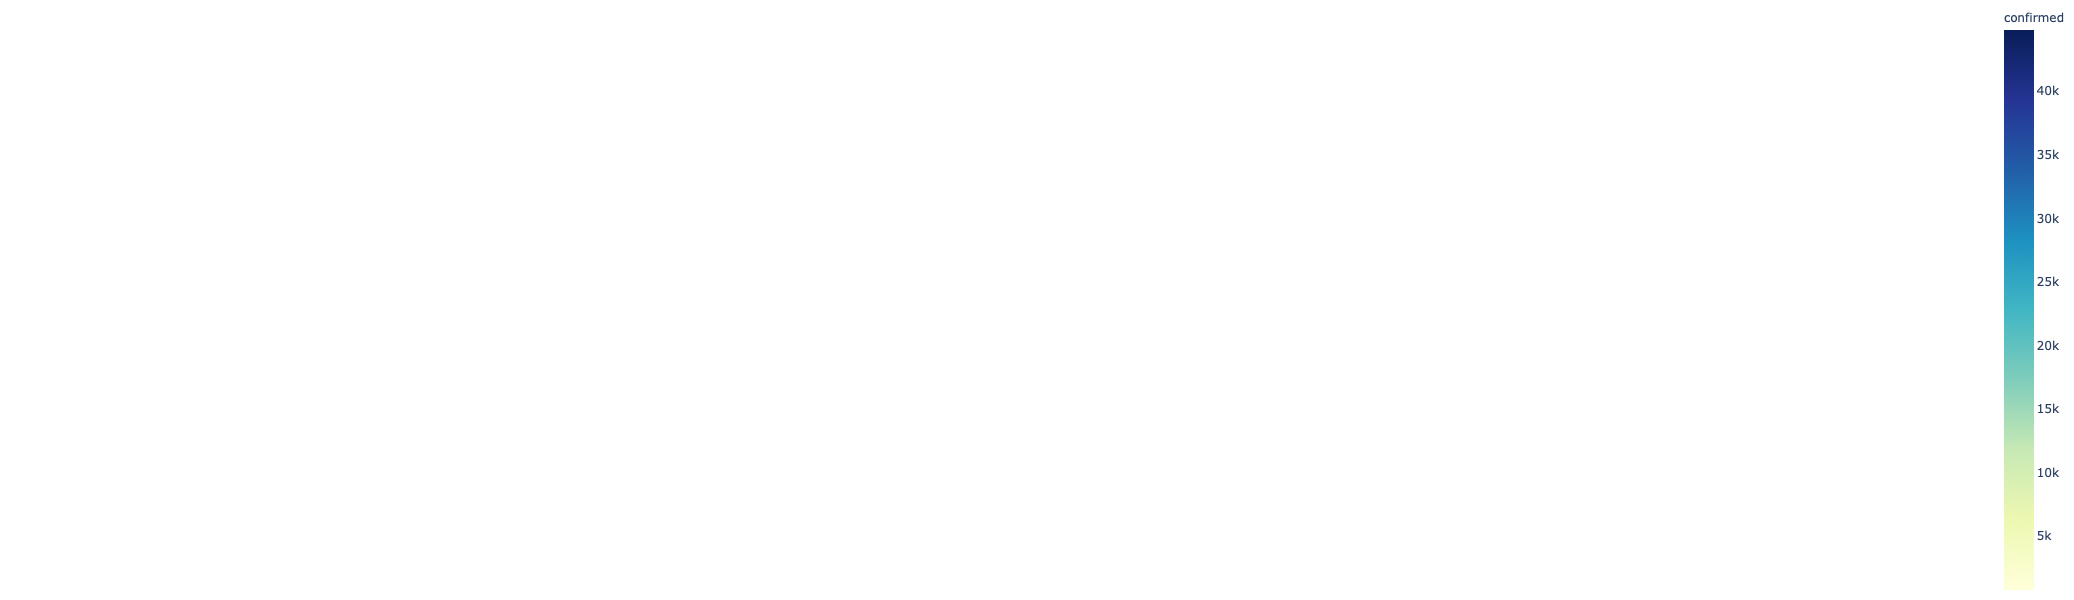

In [486]:
import plotly.express as px
df = merged #.loc[merged.region=='Europe & Central Asia', :]

fig = px.choropleth_mapbox(df, geojson=json.loads(df.to_json()), locations='iso_code', color='confirmed',
                           color_continuous_scale="YlGnBu",
#                            range_color=(0, 200000000),
#                            mapbox_style="mapbox://styles/plotlymapbox/cjvprkf3t1kns1cqjxuxmwixz",
                           mapbox_style="white-bg", #"carto-darkmatter",
                           zoom=1.2, center = {"lat": 40.9, "lon": 3.7},
                           opacity=1,
                           labels={'confirmed ':'confirmed '},
                           width=1200,
                           height=600
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.update_traces(marker=dict( #size=1,
                              line=dict(width=1,
                                        color='White')),
#                   selector=dict(mode='markers')
                 )
fig.show()

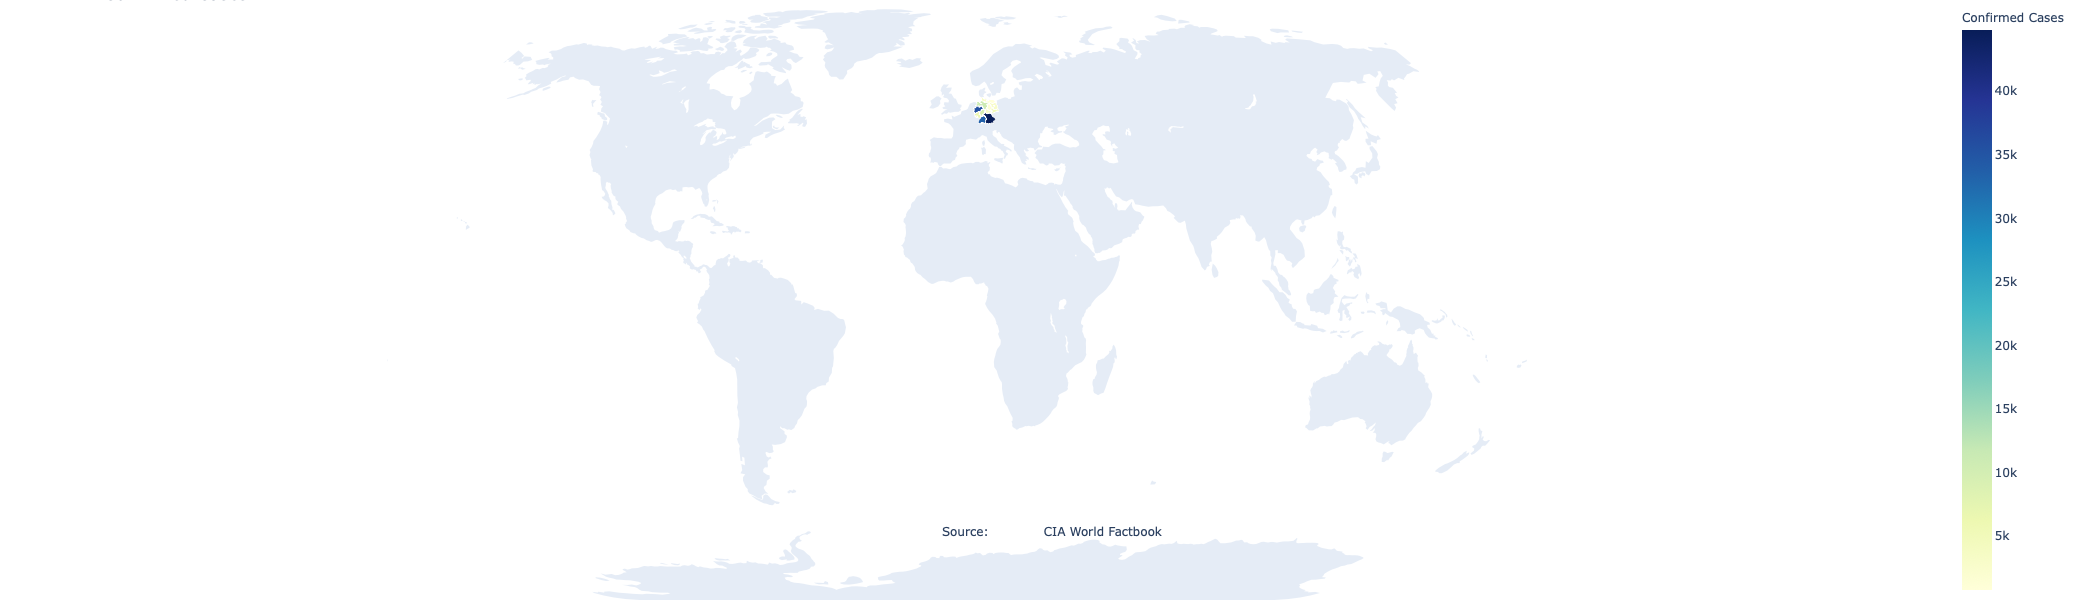

In [482]:
import plotly.graph_objects as go

fig = go.Figure(data=go.Choropleth(
    locations = merged['iso_code'],
    geojson=json.loads(merged.to_json()),
    z = merged['confirmed'],
    text = merged['land'],
    colorscale = 'YlGnBu',
#     autocolorscale=True,
#     reversescale=False,
#     zmax=200000000,
#     zmin=0,
    marker_line_color='white',
    marker_line_width=0.5,
#     colorbar_tickprefix = '$',
    colorbar_title = 'Confirmed Cases',
))

fig.update_layout(
    title_text='Confirmed Cases',
    geo=dict(
        showframe=False,
        showcoastlines=False,
        projection_type="natural earth", #go.layout.geo.Projection(type = 'Natural earth'), #'equirectangular'
    ),
    height=600,
    width=1200,
    margin=dict(t=0, b=0, l=0, r=0),
    annotations = [dict(
        x=0.55,
        y=0.1,
        xref='paper',
        yref='paper',
        text='Source: <a href="https://www.cia.gov/library/publications/the-world-factbook/fields/2195.html">\
            CIA World Factbook</a>',
        showarrow = False
    )]
)

fig.show()